# 02 – Modelado y Validación

Entrenamos y comparamos **SVM, Random Forest y XGBoost** usando `features.csv`.

**Salidas:** métricas por clase, F1 macro/weighted, matrices de confusión y (si aplica) importancias de features.


## Imports y paths

In [45]:
import os, json, joblib
import pandas as pd
from dotenv import load_dotenv

# Asegurar que Python vea la raíz del repo para importar Entrega2.src
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

from Entrega2.src.models.train_models import train_all

load_dotenv()

FEATURES_PATH = os.getenv("FEATURES_PATH", "../experiments/results/features.csv")
RESULTS_DIR   = os.getenv("RESULTS_DIR",   "../experiments/results")
MODELS_DIR    = os.getenv("MODELS_DIR",    "../experiments/models")
LOGS_DIR      = os.getenv("LOGS_DIR",      "../experiments/logs")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR,  exist_ok=True)
os.makedirs(LOGS_DIR,    exist_ok=True)

print("Paths:")
print(FEATURES_PATH, RESULTS_DIR, MODELS_DIR)


Paths:
../experiments/results/features.csv Entrega2/experiments/results Entrega2/experiments/models


## Cargar features

In [46]:
df = pd.read_csv(FEATURES_PATH)
print(df.shape)
df.head(3)


(175, 144)


,knee_left_mean,knee_left_std,knee_right_mean,knee_right_std,hip_left_mean,hip_left_std,hip_right_mean,hip_right_std,inclination_mean,inclination_std,...,center_displacement_y_std,displacement_ratio_x_y,t_start,t_end,t_duration,video_progress,frame_start,frame_end,video_id,label
0,2.809319,0.238960,1.963360,0.439324,2.854180,0.144649,2.096193,0.411019,1.448148,0.157631,...,0.051305,0.819675,2.533333,5.200000,2.666667,0.500000,76,156,006beb60-8b9e-4b79-867a-ca1c2f386ce2,sentarse
1,2.722190,0.281661,2.464425,0.362735,2.669825,0.259454,2.423046,0.261321,1.627710,0.033428,...,0.010074,3.410053,0.000000,3.500000,3.500000,0.500000,0,105,011d6524-bb00-49fc-80d5-9e97161ac9ff,ponerse_de_pie
2,3.018146,0.168501,2.892542,0.233494,2.873198,0.132569,3.017637,0.107162,0.048602,0.035068,...,0.033009,0.991129,0.400266,5.203459,4.803193,0.444444,10,130,026c2c6b-d509-4f2d-9535-5cc10e2d5042,caminar


## Entrenar modelos

In [47]:
reports = train_all(df, results_dir=RESULTS_DIR, models_dir=MODELS_DIR, logs_dir=LOGS_DIR)
# Resumen rápido
{k: v["report"]["macro avg"]["f1-score"] for k, v in reports.items()}



>>> Entrenando svm…
svm OK. Mejores params: {'clf__C': 0.5, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}

>>> Entrenando rf…
rf OK. Mejores params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}

>>> Entrenando xgb…
xgb OK. Mejores params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


{'svm': 0.9353187042842215,
 'rf': 0.9016877519032691,
 'xgb': 0.9016877519032691}

## Ver métricas detalladas

In [48]:
import json, os, pandas as pd

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

svm_rep = load_json(os.path.join(RESULTS_DIR, "svm_report.json"))
rf_rep  = load_json(os.path.join(RESULTS_DIR, "rf_report.json"))
xgb_rep = load_json(os.path.join(RESULTS_DIR, "xgb_report.json"))

def to_df(rep):
    # rep es el classification_report(output_dict=True)
    rows=[]
    for k,v in rep.items():
        if isinstance(v, dict) and "precision" in v:
            rows.append({"label": k, **v})
    return pd.DataFrame(rows)

display(to_df(svm_rep).round(3))
display(to_df(rf_rep).round(3))
display(to_df(xgb_rep).round(3))


,label,precision,recall,f1-score,support
0,caminar,0.933,1.000,0.966,14.0
1,girar,1.000,0.833,0.909,6.0
2,ponerse_de_pie,1.000,0.875,0.933,8.0
3,sentarse,0.875,1.000,0.933,7.0
4,macro avg,0.952,0.927,0.935,35.0
5,weighted avg,0.948,0.943,0.942,35.0


,label,precision,recall,f1-score,support
0,caminar,0.933,1.000,0.966,14.0
1,girar,1.000,0.833,0.909,6.0
2,ponerse_de_pie,1.000,0.750,0.857,8.0
3,sentarse,0.778,1.000,0.875,7.0
4,macro avg,0.928,0.896,0.902,35.0
5,weighted avg,0.929,0.914,0.913,35.0


,label,precision,recall,f1-score,support
0,caminar,0.933,1.000,0.966,14.0
1,girar,1.000,0.833,0.909,6.0
2,ponerse_de_pie,1.000,0.750,0.857,8.0
3,sentarse,0.778,1.000,0.875,7.0
4,macro avg,0.928,0.896,0.902,35.0
5,weighted avg,0.929,0.914,0.913,35.0


## Mostrar los PNG de confusión e importancias

Confusion matrix: svm


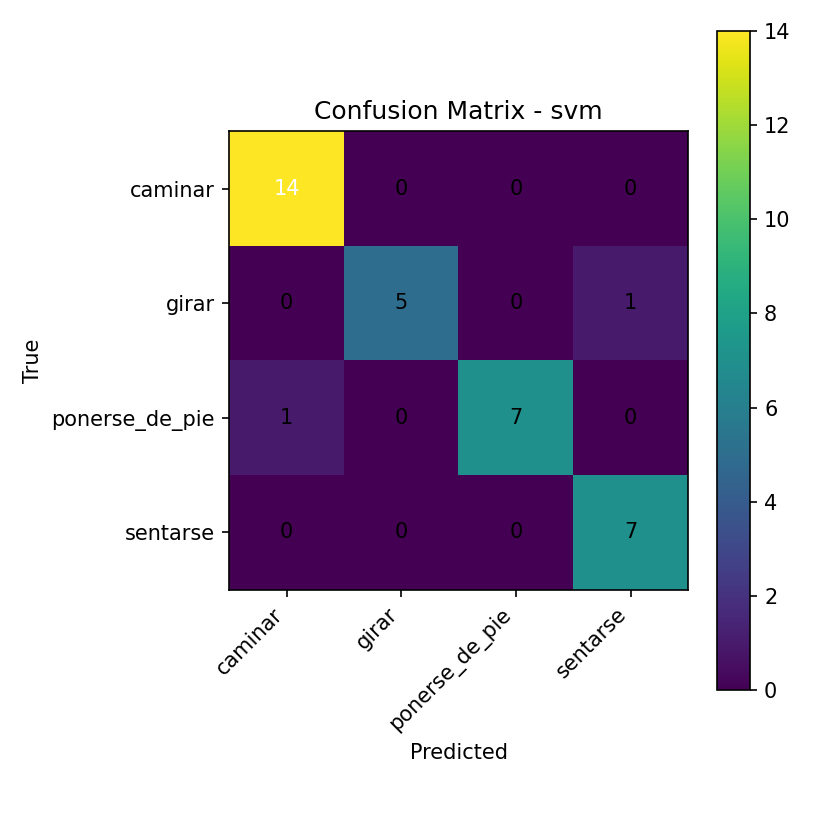

Confusion matrix: rf


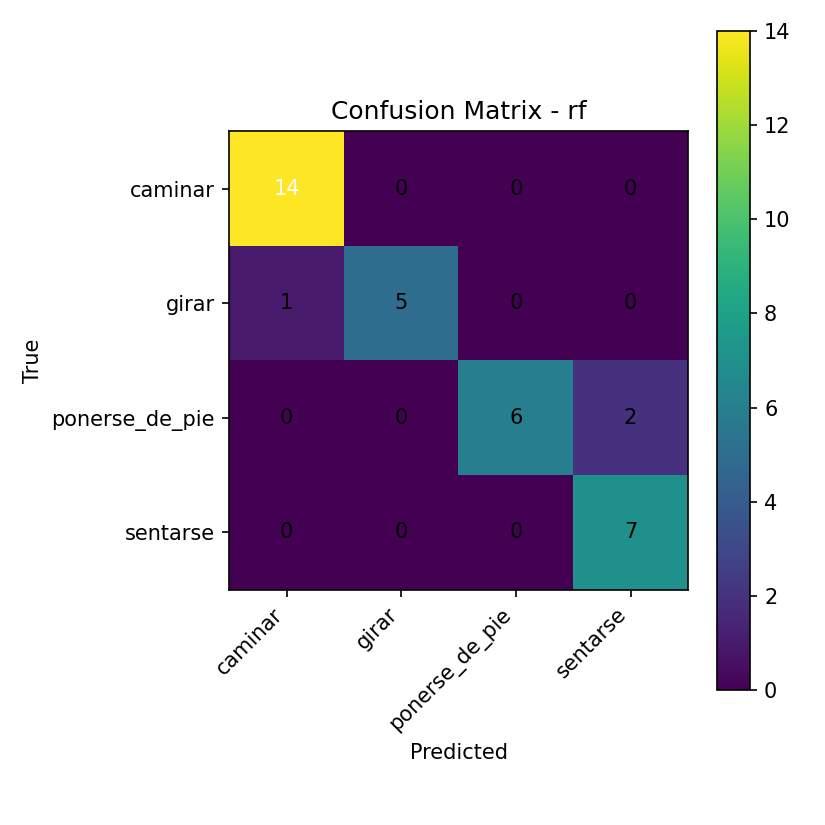

Confusion matrix: xgb


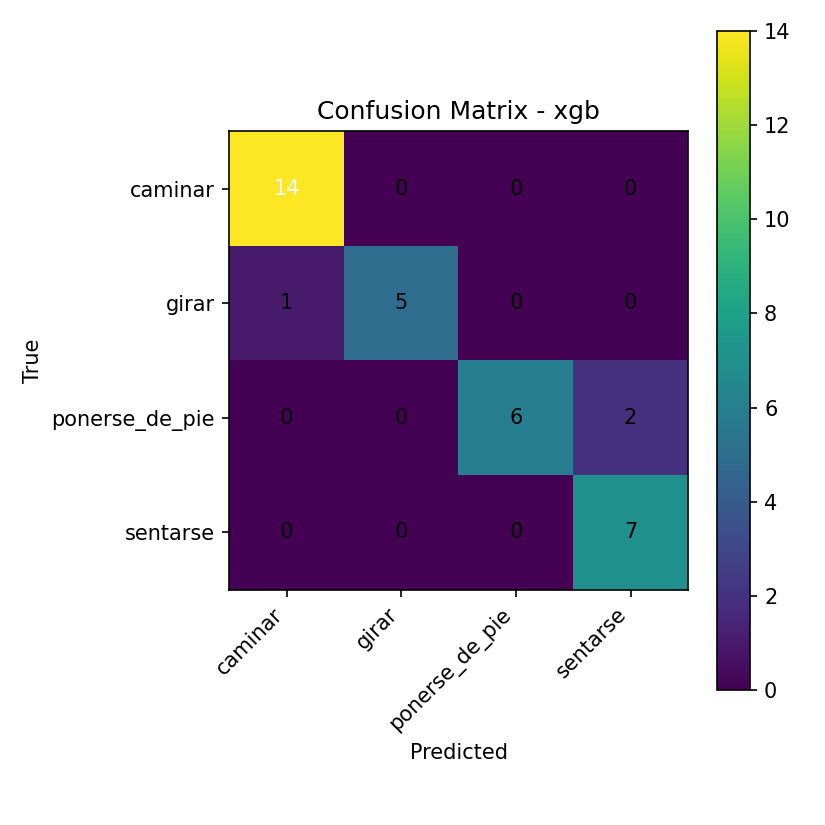

Feature importances: rf


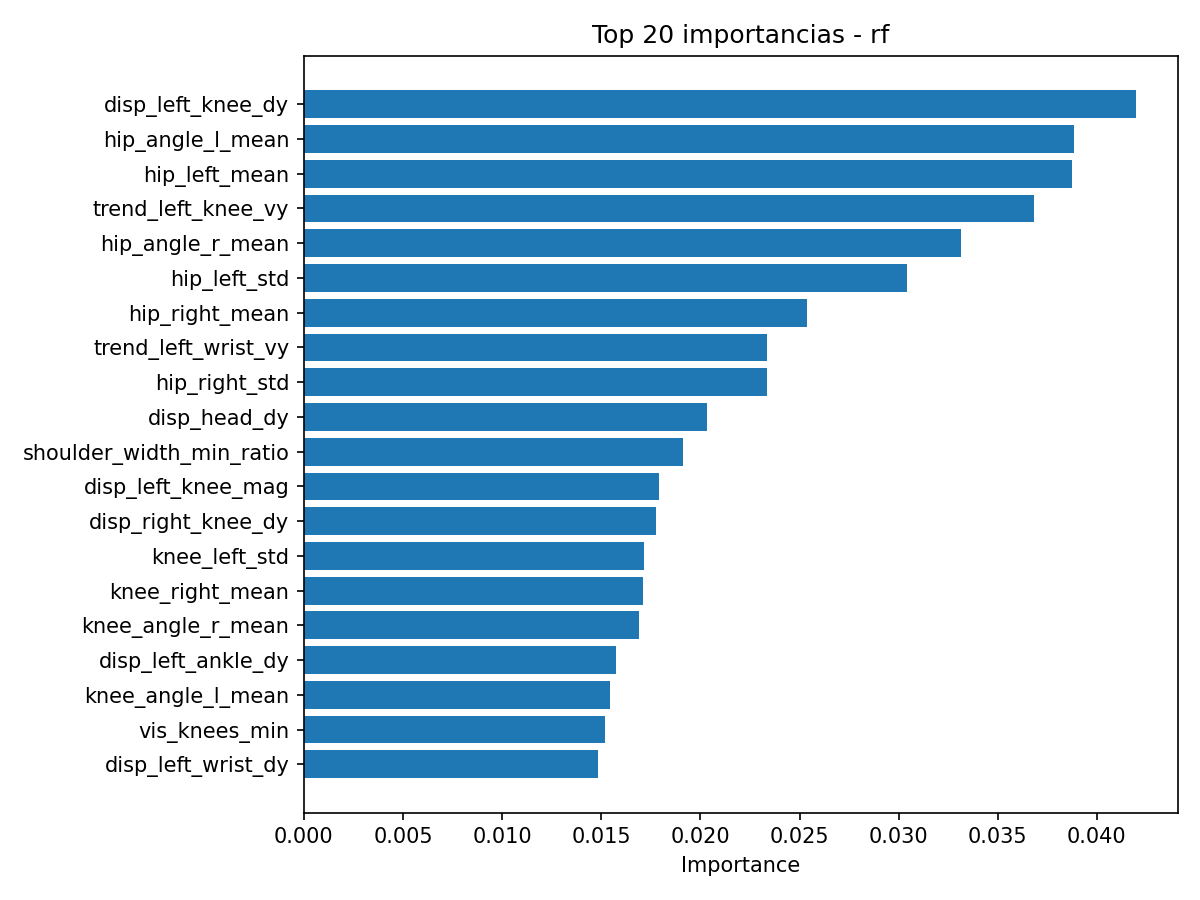

Feature importances: xgb


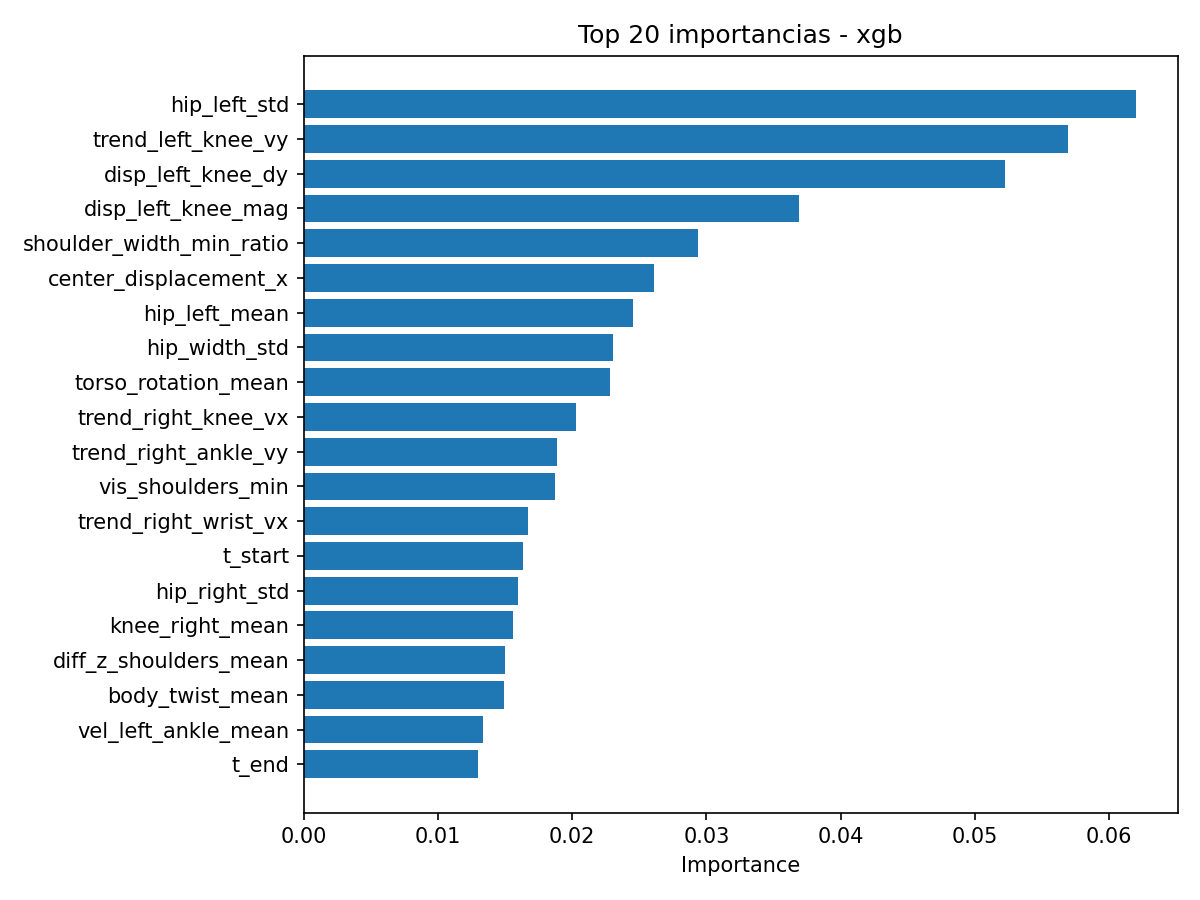

In [49]:
from IPython.display import Image, display

for name in ["svm","rf","xgb"]:
    png = os.path.join(RESULTS_DIR, f"{name}_confusion_matrix.png")
    if os.path.exists(png):
        print(f"Confusion matrix: {name}")
        display(Image(filename=png))

for name in ["rf","xgb"]:
    png = os.path.join(RESULTS_DIR, f"{name}_feature_importance_top20.png")
    if os.path.exists(png):
        print(f"Feature importances: {name}")
        display(Image(filename=png))


## Conclusiones del modelado

- Comparación de F1 (macro/weighted)
- Clases donde cada modelo acierta/falla más.
- Observaciones de matriz de confusión (p.ej., confusión entre *sentarse* y *ponerse_de_pie*).
- Importancias (RF/XGB): ¿qué ángulos o velocidades pesan más?
- Mejor modelo seleccionado y por qué (precisión + consideraciones de despliegue en tiempo real).
